In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

#from pushover import notify
#from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
bs = 32

In [24]:
import cv2
import numpy as np
from torch.utils.data import Dataset
import torch


class ImageDataset(Dataset):
    """
    Creates image dataset of 32X32 images with 3 channels
    requires numpy and cv2 to work
    """

    def __init__(self, file_path, train=True, transform=None):
        print('Loading data')
        data = np.load(file_path, allow_pickle=True)
        print('Done loading data')
        data = np.array(data.item().get('image_observation'))

        self.n = data.shape[0]
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]

        if self.transform is not None:
            img = self.transform(img)

        label = 0
        return img, label

    def __len__(self):
        return len(self.data)


In [47]:

#data_file_path = '/home/misha/research/vqvae/data/reacher_no_target_length100_paths_50.npy'
data_file_path = '/home/misha/research/vqvae/data/two_blocks_length100_paths_100.npy'
#data_file_path = '/home/misha/research/vqvae/data/just_place_length100_paths_600.npy'


dataset = ImageDataset(data_file_path, train=True,
                             transform=transforms.Compose([
                                transforms.ToTensor(), 
                             ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset), len(dataloader)

Loading data
Done loading data


(10000, 313)

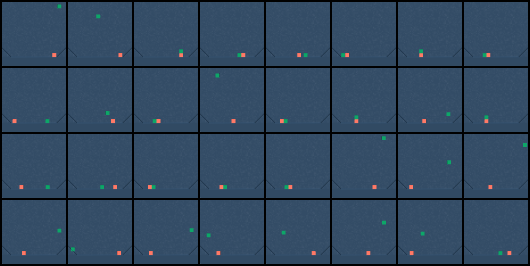

In [48]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')


In [28]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [29]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [30]:
class VAE(nn.Module):
    def __init__(self, img_dim=32,image_channels=3, h_dim=1024, z_dim=128,device=None):
        super(VAE, self).__init__()
        
        assert img_dim == 32 or img_dim == 64, 'img_dim must be 32 or 64'
        if img_dim == 32:
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(64, 256, kernel_size=4, stride=2),
                nn.ReLU(),
                Flatten()
            ).to(device)
            
            self.decoder = nn.Sequential(
                UnFlatten(),
                nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 32, kernel_size=6, stride=2),
                nn.ReLU(),
                nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
                nn.Sigmoid(),
            ).to(device)
        
        if img_dim == 64:
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=4, stride=2),
                nn.ReLU(),
                Flatten()
            ).to(device)
            
            self.decoder = nn.Sequential(
                UnFlatten(),
                nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
                nn.ReLU(),
                nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
                nn.Sigmoid(),
            ).to(device)
        
        
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        
        self.device =device
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(self.device)        
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x,z, mu, logvar

In [31]:
image_channels = fixed_x.size(1)
img_dim = fixed_x.size(-1)

In [32]:
model = VAE(img_dim=img_dim,image_channels=image_channels,z_dim=128,device=device).to(device)
#model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [34]:
def loss_fn(recon_x, x, mu, logvar):
    x = x.to(device)
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [35]:
!rm -rfr reconstructed
!mkdir reconstructed

In [36]:
epochs = 50

In [37]:
img_dim

64

In [38]:
filename = '/home/misha/research/baselines/vae/saved_models/just_place_vae.pth'
train = False 
if train:
    epoch = 0
    while epoch < epochs:

        for idx, (images, _) in enumerate(dataloader):
            recon_images,z, mu, logvar = model(images.to(device))
            loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.item()/bs, bce.item()/bs, kld.item()/bs)
            if idx % 100 == 0 and idx >0:
                epoch+=1
                print(to_print)
                break

    # notify to android when finished training
    #notify(to_print, priority=1)

    torch.save(model.state_dict(),  filename)

In [39]:
#filename = 'reacher_vae.pth'
#torch.save(model.state_dict(), 'saved_models/' + filename)

In [40]:
def compare(x):
    x=x.to(device)
    recon_x,_, _, _ = model(x)
    return torch.cat([x, recon_x])

In [41]:
!pwd

/home/misha/research/baselines/vae/notebooks


In [66]:
path = '/home/misha/research/baselines/vae/saved_models/two_blocks_vae.pth'
from vae.models import VAE 
model = VAE(img_dim=64,image_channels=3,z_dim=128,device=device).to(device)

model.load_state_dict(torch.load(path))

<All keys matched successfully>

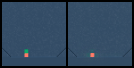

In [67]:

from vae.envs.stacker import Stacker

env = Stacker()
#model = reacher.model

# sample = torch.randn(bs, 1024)
# compare_x = vae.decoder(sample)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [68]:
fixed_x.shape
_,z,_,_ = model(fixed_x.to(device))

z.shape

torch.Size([1, 128])

In [69]:
import numpy as np
from vae.envs.stacker import Stacker
env = Stacker(path_length=500)

o = env.reset()
dists = []

z = o['achieved_goal']

for _ in range(10):
    a = env.action_space.sample()
    o,r,d,_ = env.step(a)
    z2 = o['achieved_goal']
    d = np.linalg.norm(z-z2)
    dists.append(d)

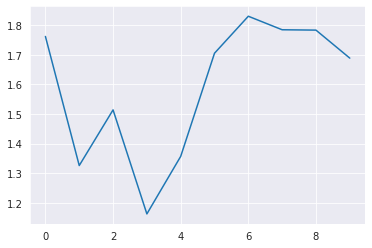

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.plot(dists)